In [54]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib
from matplotlib import cm
import pandas as pd
import numpy.random as rdm
from mpl_toolkits.mplot3d import Axes3D
from numpy import meshgrid
from tqdm import tqdm
from scipy.optimize import fsolve

plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML
data_path  = "/Users/asaaf/Desktop/Stage/"

plt.ion()
plt.clf()

plt.show()


<Figure size 432x288 with 0 Axes>

In [55]:
#%matplotlib notebook


We load the data:

In [56]:
df = pd.read_csv(data_path+"sweden.txt", sep = '\t')
print(df)
dr = pd.read_csv(data_path+"Recovery_newbies.txt", sep = '\t')
print(dr)
dd = pd.read_csv(data_path+"Death.txt", sep = '\t')
print(dd)

    Suède: infective
0                  1
1                  1
2                  1
3                  1
4                  1
..               ...
77             18633
78             15878
79             16288
80             16903
81             16612

[82 rows x 1 columns]
    New_Recoveries
0                0
1                0
2                0
3                0
4                0
..             ...
77               0
78            3069
79               0
80               0
81             897

[82 rows x 1 columns]
    Death per day
0               0
1               0
2               0
3               0
4               0
..            ...
77           2679
78           2789
79           2854
80           2941
81           3040

[82 rows x 1 columns]


We don't want to have a dictionnary type.

In [57]:
I = df.values


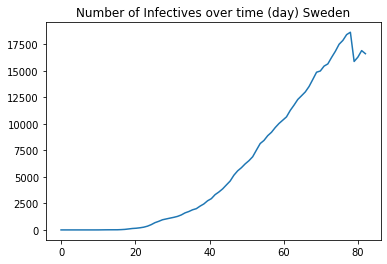

In [58]:
x = np.linspace(0,82,82)
plt.plot(x,I)
plt.title("Number of Infectives over time (day) Sweden")
plt.show()

Recover = recovered + dead (people who cannot give the virus to any susceptible)

We compute R

In [59]:
D = dd.values
R = dr.values

for i in range(81):
    R[i+1] = R[i] + R[i+1]
R = R + D



S_0 = Population totale de Suède en 2020

In [60]:
S_0 = 10183175


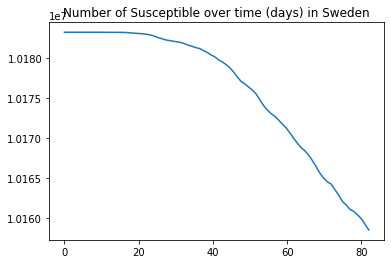

In [61]:
S = S_0 - I - R
x = np.linspace(0,82,82)
plt.plot(x,S)
plt.title("Number of Susceptible over time (days) in Sweden")
plt.show()

Text(0.5, 1.0, 'Error')

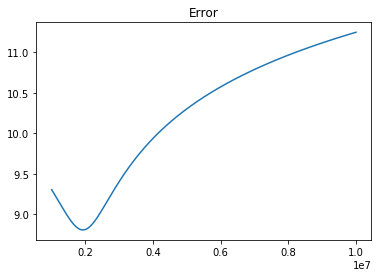

In [62]:

alpha = np.linspace(10**(6),10**(7),10000)
alpha = np.array(alpha)
error = np.ones(10000)
for i in range(10000):
    error[i] = np.linalg.norm(I - (-S + alpha[i]*np.log(S)  + S_0 - alpha[i]*np.log(S_0) +1 ))
plt.plot(alpha,np.log(error))
plt.title("Error")

Function to find the index where the minimum is in a vector:

In [63]:
def IndiceMinimum(liste):
    mini = liste[0]
    longueur=len(liste)
    indice_min = 0
    for i in range(longueur):
        if liste[i] <= mini:
            mini = liste[i]
            indice_min = i
    return indice_min


In [64]:
alpha_perf = (alpha[IndiceMinimum(error)])
print("Index minimum = ", IndiceMinimum(error))
print("alpha is then ", alpha_perf)
print("R_0 is estimated to be equal to", (1/alpha[IndiceMinimum(error)])*S_0 )
print("The error is equal to ", error[IndiceMinimum(error)])


rho = 1/alpha[IndiceMinimum(error)]
alpha_perf = alpha[IndiceMinimum(error)]

Index minimum =  1026
alpha is then  1923492.3492349235
R_0 is estimated to be equal to 5.2941073584464196
The error is equal to  6692.343080554304


From the theory, r/a = 1/alpha. We can see that the error is pretty important still $(4.5x10^{7})$ which is why the $R_0$ approximately 5.3 is still too big ($R_0$ is evaluated to be in between 2 and 3 for the Covid 19).

The error is equal to  6692.343080554304


Text(0.5, 1.0, 'Curve fitting to estimate $R_0$')

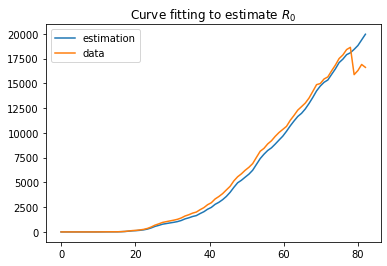

In [65]:
plt.plot(x,-S + np.log(S)*alpha[IndiceMinimum(error)]+ S_0 - alpha[IndiceMinimum(error)]*np.log(S_0) +1,label="estimation")
plt.plot(x,I, label="data")
print("The error is equal to ", error[IndiceMinimum(error)])
plt.legend()
plt.title("Curve fitting to estimate $R_0$")

I found studies saying that $R_0$ in Sweden is equal to (approximately) 1.4  if we consider the data from 1st of April til the 25th.
Let's check it.

Text(0.5, 1.0, 'Population of Infective in Sweden from the 1st to the 25th of April.')

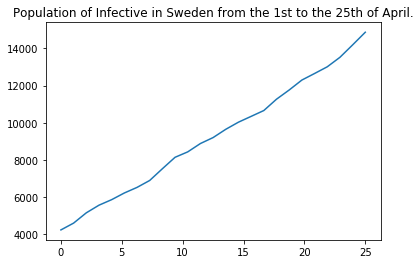

In [66]:

I_test = I[44:69]
S_test = S[44:69]
y = np.linspace(0,25,25)
plt.plot(y,I_test)


plt.title("Population of Infective in Sweden from the 1st to the 25th of April.")

R_0 is estimated to be equal to [5.2314254]
The error is equal to  6692.343080554304


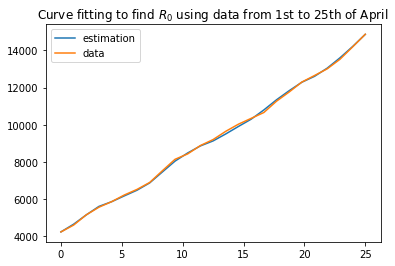

In [67]:
S_0 = S_test[0]
beta = np.linspace(9*10**(5),10**(7),10000)
beta = np.array(beta)
error_t = np.ones(10000)
for i in range(10000):
    error_t[i] = np.linalg.norm(I_test - (-S_test + beta[i]*np.log(S_test)  + S_0 - beta[i]*np.log(S_0) +I_test[0] ))
print("R_0 is estimated to be equal to",(1/beta[IndiceMinimum(error_t)])*S_0)

plt.plot(y,-S_test + 1945694*np.log(S_test)  + S_0 - 1945694*np.log(S_0) +I_test[0],label="estimation" )
plt.plot(y,I_test,label="data")


plt.title("Curve fitting to find $R_0$ using data from 1st to 25th of April")
plt.legend()
print("The error is equal to ", error[IndiceMinimum(error)])



Again, we find a R_0 close to 5.2 that fits perfectly the curve. 
This is very different from 1.1 which means that the SIR model does not work for a big geographical area. It is actually known to work with small geographical areas better which is why we will implement it to predict the situation in the region of Stokholm.


# A. EULER Method

Now, we try to estimate a and r using Euler Method.


We build the numerical solutions $S_{seq}, I_{seq}, R_{seq}$ using the formulas from the theory using $\Delta t = 1$.
From reading different articles, we have an idea of the intervals where $r$ and $a$ lie.
The error vector is then a matrix because we compute the error for every pair of $r$ and $a$ in the intervals chosen and we then take the couple that minimizes the error.

Since I feel that this way of estimating r and a is very approximative if I do it at the same time (I tried and the error is reaaaaally big). I was wondering if maybe
it wouldn't be better to try to estimate r and then find the corresponding a with the r/a that fits 
the data we found earlier. I compute it here:

The predictions seems a bit too high for me (it reaches 5M people i.e half of the Swedish population infected by the virus).
It gives a good idea on the dynamic of the epidemic ( reaches a maximum and then goes down).
SIR seems to be a good model to use when the parameters a and r are known. The errors are quite big when we use it to estimate them though.
It is not realistic enough. 

# Stokholm: data 21th of March - 17th of May

In [68]:
df = pd.read_csv(data_path+"Stokholm_I_excel.txt", sep = '\t')
print(df)



    Stockholm:Infective_excel
0                           1
1                           2
2                           1
3                           0
4                           1
..                        ...
77                        117
78                        147
79                         64
80                         55
81                         15

[82 rows x 1 columns]


In [69]:
dr = pd.read_csv(data_path+"Stokholm_recovery_ratecopie.txt", sep = '\t')
print(dr)

    Stokholm: Recovery Rate
0                    0.4444
1                    0.4300
2                    0.3700
3                    0.2857
4                    0.2051
5                    0.1700
6                    0.1322
7                    0.1270
8                    0.0988
9                    0.0816
10                   0.3012
11                   0.2506
12                   0.3641
13                   0.3547
14                   0.3383
15                   0.3006
16                   0.2575
17                   0.2298
18                   0.2054
19                   0.3046
20                   0.3005
21                   0.2977
22                   0.2931
23                   0.2694
24                   0.2405
25                   0.2921
26                   0.2821
27                   0.2669
28                   0.2632
29                   0.2582
30                   0.2376
31                   0.2211
32                   0.2139
33                   0.2036
34                  

In [70]:
dd = pd.read_csv(data_path+"Stokholm_D.txt", sep = '\t')
print(dd)

    Stokholm: Death
0                 9
1                15
2                19
3                37
4                43
5                60
6                63
7                68
8                89
9               104
10              149
11              179
12              204
13              225
14              251
15              303
16              351
17              419
18              486
19              510
20              523
21              528
22              543
23              616
24              702
25              795
26              816
27              897
28              921
29              944
30             1022
31             1070
32             1128
33             1192
34             1208
35             1209
36             1237
37             1257
38             1319
39             1496
40             1417
41             1428
42             1430
43             1463
44             1524
45             1551
46             1604
47             1660
48             1674


Couldn't find the number of recoveries so I took the recovery rate computed in Worldmeter and computed the recovery rate with it. 

In [71]:

N = 57
Rate = dr.values
I_sto = df.values
for i in range(len(I_sto)-1):
    I_sto[i+1] = I_sto[i+1] + I_sto[i]
    

I_sto =I_sto[-N:len(I_sto),]
I_sto = np.array(I_sto)
D_sto = dd.values
R_sto = np.zeros(N)
R_sto = Rate*I_sto + D_sto
R_sto = np.array(R_sto)

Text(0.5, 1, 'Infective people in Stokholm')

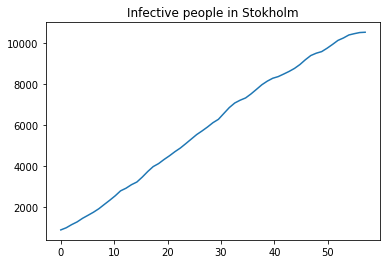

In [72]:
x = np.linspace(0,N,N)
plt.plot(x,I_sto)
plt.savefig("Infective_Sto.png")


plt.title("Infective people in Stokholm")

Text(0.5, 1.0, 'Recovered people in Stokholm')

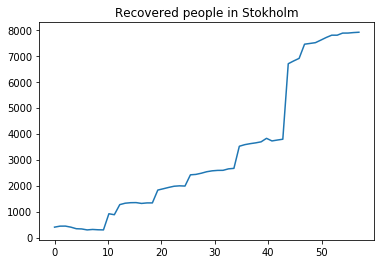

In [73]:
plt.plot(x,R_sto)
plt.title("Recovered people in Stokholm")

We have the total population of Stokholm:
    

Text(0.5, 1.0, 'Susceptible people in Stokholm')

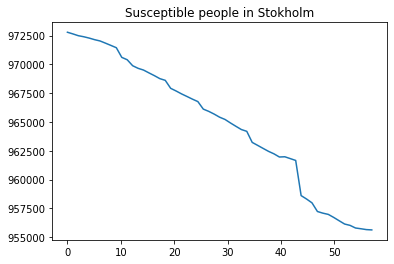

In [83]:
S_sto_0 = 974073
S_sto =S_sto_0  - R_sto - I_sto 
plt.plot(x,S_sto)
plt.title("Susceptible people in Stokholm")

Text(0.5, 1.0, 'Error')

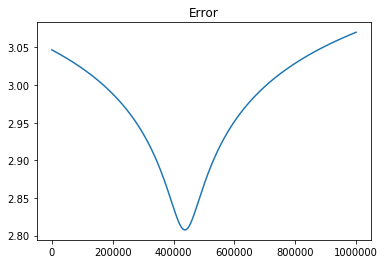

In [75]:
alpha = np.linspace(-10**(2),10**(6),10000)
alpha = np.array(alpha)
error = np.ones(10000)
for i in range(10000):
    error[i] = np.linalg.norm((I_sto - (-S_sto + alpha[i]*np.log(S_sto)  + S_sto_0 - alpha[i]*np.log(S_sto_0) +I_sto[0] )),2)**2
plt.plot(alpha,np.log(np.log(error)))
plt.title("Error")

In [76]:
alpha_perf = (alpha[IndiceMinimum(error)])
print("Index minimum = ", IndiceMinimum(error))
print("alpha is then ", alpha_perf)
print("The error is equal to ", error[IndiceMinimum(error)])
print("R_0 is estimated to be equal to", (1/alpha[IndiceMinimum(error)])*S_sto_0 )
R_0 = (1/alpha[IndiceMinimum(error)])*S_sto_0
rho = 1/alpha[IndiceMinimum(error)]
alpha_perf_sto = alpha[IndiceMinimum(error)]

Index minimum =  4374
alpha is then  437387.4887488749
The error is equal to  15688366.419046087
R_0 is estimated to be equal to 2.2270252923472666


The R_0 we found is closed to the official one for the COVID 19. It is okay to find an error this big since with take the L2 norm and we square it. If the error for a day is about 10 people, taken over 57 days and squared, the number is big.

Text(0.5, 1, 'Curve fitting with R_0 = 2.24 approximately')

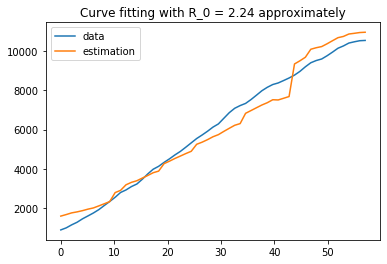

In [81]:
plt.plot(x,I_sto, label="data")
plt.plot(x,-S_sto + np.log(S_sto)*alpha_perf_sto+ S_sto_0 - alpha_perf_sto*np.log(S_sto_0) + I_sto[0],label="estimation")
plt.legend()
plt.savefig("Estimation.png")
plt.title("Curve fitting with R_0 = 2.24 approximately")

index of minimum = 1178
r is then 1.0603942494249425e-07
 a is then 0.04638031778397237


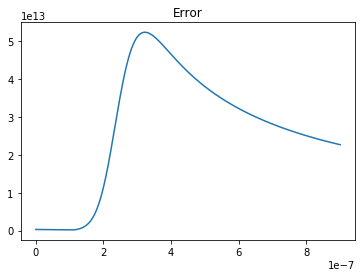

In [78]:
N = 57
S_seq = np.zeros(N)
R_seq = np.zeros(N)
I_seq = np.zeros(N)
S_seq[0] = S_sto_0
R_seq[0] = R_sto[0]
I_seq[0] = I_sto[0]
r = np.linspace(10**(-11),9*10**(-7),10000)
r  = np.array(r)
error_seq = np.ones(10000)

for n in range(10000):
    a = alpha_perf_sto*r[n]
    for i in range(N-1):
        S_seq[i+1] = S_seq[i] - r[n]*S_seq[i]*I_seq[i]
        I_seq[i+1] = I_seq[i] + r[n]*S_seq[i]*I_seq[i] - a*I_seq[i]
        R_seq[i+1] = R_seq[i] + a*I_seq[i]
    error_seq[n] = np.linalg.norm((I - I_seq),2)**2
print("index of minimum =", np.argmin(error_seq))
j = np.argmin(error_seq)
plt.plot(r,error_seq)
plt.title("Error")
print("r is then", r[j])
print(" a is then",alpha_perf_sto*r[j])
r = r[j]
a =alpha_perf_sto*r

Text(0.5, 1, 'infective: estimation vs data')

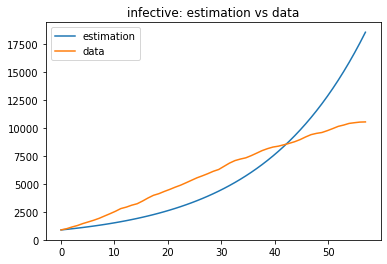

In [82]:
M = 220
S_seq_perf = np.zeros(M)
R_seq_perf = np.zeros(M)
I_seq_perf = np.zeros(M)
S_seq_perf[0] = S_sto_0
R_seq_perf[0] = R_sto[0]
I_seq_perf[0] = I_sto[0]
for i in range(M-1):
    S_seq_perf[i+1] = S_seq_perf[i] - r*S_seq_perf[i]*I_seq_perf[i]
    I_seq_perf[i+1] = I_seq_perf[i] + r*S_seq_perf[i]*I_seq_perf[i] - a*I_seq_perf[i]
    R_seq_perf[i+1] = R_seq_perf[i] +a*I_seq_perf[i]

I_predict = I_seq_perf[:N,]
plt.plot(x,I_predict, label="estimation")
plt.plot(x,I_sto,label="data")
plt.legend()
plt.savefig("Infective.png")

plt.title("infective: estimation vs data")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 1, 'Predictions in Stokholm for the following days')

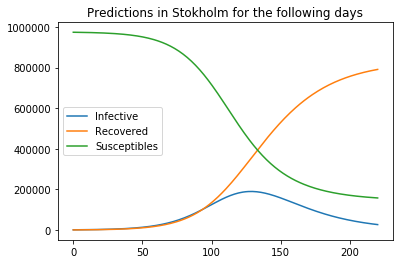

In [80]:
y = np.linspace(0,M,M)
plt.plot(y,I_seq_perf,label ="Infective")
plt.plot(y,R_seq_perf,label = "Recovered" )
plt.plot(y,S_seq_perf, label ="Susceptibles")
plt.legend()
plt.savefig("Covid19.eps")
plt.title("Predictions in Stokholm for the following days")


In [29]:
i = np.argmax(I_seq_perf)
print(I_seq_perf[i])
print("The maximum is",S_seq_perf[i])
print("The theoretical maximum is",a/r)
print("The contagious time of an Infective is",1/(r*S_sto_0))


189791.54610989176
The maximum is 431793.54103012953
The theoretical maximum is 437387.4887488749
The contagious time of an Infective is 9.681466135352409


The maxima (theoretical and numerical) are close to each other (since we are dealing with hundreds of thousands of people, 6000 of difference is not a lot) which is a sign that the model 
is working. The life contagious time of an infective (for how long someone who has the disease can give it to a susceptible) is estimated to be around 10 days which is what we found hence the SIR model is working for a small geographical area.

In Stokholm, we predict that 192936 people will get affectied by the virus.

# Part II.

Here we deal with density: $S = S(x,t)$ so $S_0(x) = \frac{S_{{sto}_0}}{\text{ superficie de Stokholm }} = 5181\text{ people}/km^2.$

Numerical method for the travelling wave solution when $\mathbb{x}$ has one dimension.

In [84]:
#initialization:
delta_t = 0.01
delta_x = 1
 
x = 500
y = 650
t1 = 0
t2=500
tstep = int(abs(t2-t1)/delta_t)
xstep = int((y-x)/delta_x)
S = np.ones((xstep,tstep))
I = np.zeros((xstep,tstep))
R = np.zeros((xstep,tstep))
Z = np.zeros((xstep,tstep))
N = np.zeros(tstep)
l = 1/R_0
c = 2*(1-l)**(1/2)

#setting the vectors of x and t:
X = np.linspace(x,y,xstep)
T = np.linspace(t1,t2,tstep)
#initial conditions: time = 0:

I[:int(2*xstep/3),0] = 1/5181


PDE and Von Neumann Conditions:

In [85]:
for m in range(1,tstep):
    S[1:-1, m] = (delta_t/(delta_x**2))*(S[2:,m-1] - 2*S[1:-1,m-1] + S[:-2,m-1]) - delta_t*S[1:-1,m-1]*I[1:-1,m-1]+S[1:-1,m-1]
    I[1:-1, m] = (delta_t/(delta_x**2))*(I[2:,m-1] - 2*I[1:-1,m-1] + I[:-2,m-1]) + delta_t*S[1:-1,m-1]*I[1:-1,m-1]+(1- delta_t*l)*I[1:-1,m-1]
#Von Neumann boundary conditions:
    S[0,m] = S[1,m]
    I[0,m] = I[1,m]
    S[-1,m] = S[-2,m] 
    I[-1,m] = I[-2,m] 

In [86]:
for j in range((tstep)):
    Z[:,j] = X - c*T[j]*np.ones(xstep)



The column of Z has a fixed t and x moves:$ Z[i,j] = -c(t_1+ (m+j)\Delta_t) + x_i$, $Z[p,j] =  -c(t_1+ (m+j)\Delta_t) + x_p$ where x starts from a and goes to b.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 1, 'Traveling Wave t =10.00020000400008 ')

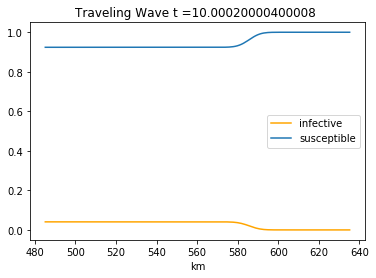

In [87]:
t = 1000
plt.plot(Z[:,t],I[:,t], color = 'orange',label = "infective")
plt.plot(Z[:,t],S[:,t],label = "susceptible")
plt.xlabel("km")
plt.legend()
plt.savefig("travellingwave10.eps")
plt.title("Traveling Wave t ={} ".format(T[t]) )




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 1, 'Traveling Wave t =40.00080001600032 ')

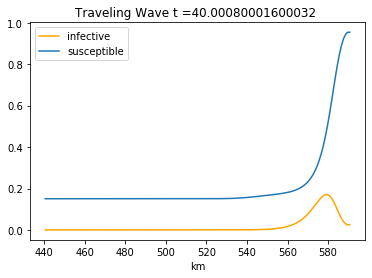

In [92]:
t = 4000
plt.plot(Z[:,t],I[:,t], color = 'orange',label = "infective")
plt.plot(Z[:,t],S[:,t],label = "susceptible")
plt.xlabel("km")
plt.legend()
plt.savefig("travellingwave25.eps")
plt.title("Traveling Wave t ={} ".format(T[t]) )




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 1, 'Traveling Wave t =50.001000020000404 ')

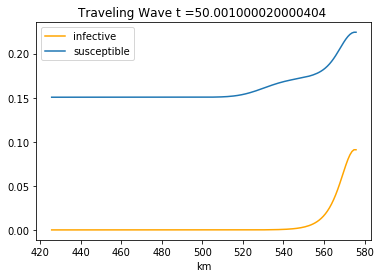

In [89]:
t = 5000
plt.plot(Z[:,t],I[:,t], color = 'orange',label = "infective")
plt.plot(Z[:,t],S[:,t],label = "susceptible")
plt.xlabel("km")
plt.legend()
plt.savefig("travellingwave50.eps")
plt.title("Traveling Wave t ={} ".format(T[t]) )



In [36]:
from PIL import Image

1.0


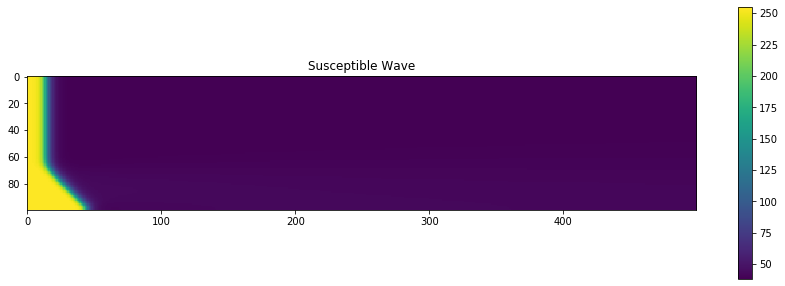

In [37]:
print(S.max())
Simg = Image.fromarray(255/S.max()*S.astype(np.float))
Simg = Simg.resize((500, 100))
plt.figure(figsize=((15, 5)))
plt.imshow(np.array(Simg))
plt.title("Susceptible Wave")


plt.colorbar()
plt.savefig("image2.eps")

0.19187860021511735


Text(111.375, 0.5, 'space (x domain)')

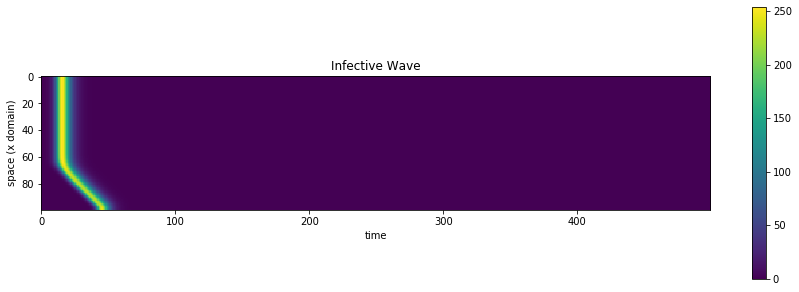

In [37]:
print(I.max())
Iimg = Image.fromarray(255/I.max()*I.astype(np.float))
Iimg = Iimg.resize((500, 100))
plt.figure(figsize=((15, 5)))
plt.imshow(np.array(Iimg))

plt.colorbar()
plt.savefig("image.eps")

plt.title("Infective Wave")
plt.xlabel("time")
plt.ylabel("space (x domain)")


We try to estimate the exact solution numerically that is using the formula we have for z really big and using the backward Euler Method. 

Numerical method for the travelling wave solution when $\mathbb{x}$ has two dimensions.

In [38]:
#initialization:
delta_t = 0.01
delta_x = 1
delta_y = 1
x1 = 500
x2 = 550
y1 = 600
y2 = 650
t1 = 0
t2=500
tstep = int(abs(t2-t1)/delta_t)
xstep = int((x2-x1)/delta_x)
ystep = int((y2-y1)/delta_y)
S2 = np.ones((xstep,ystep,tstep))
I2 = np.zeros((xstep,ystep,tstep))
R2 = np.zeros((xstep,ystep,tstep))
Z2 = np.zeros((xstep,ystep,tstep))
l = 1/R_0
c = 2*(1-l)**(1/2)
r = 800
#setting the vectors of x and t:
x = np.linspace(x1,x2,xstep)
y = np.linspace(y1,y2,ystep)
T = np.linspace(t1,t2,tstep)

#initial conditions: time = 0:
for k in range(xstep):
    for j in range(ystep):
        if np.sqrt((x[k]**2)+(y[j]**2)) < r:
            I2[k,j,0] = 1/5181
        else:
            break

In [39]:
for m in range(1,tstep):
    S2[1:-1,1:-1, m] = (delta_t/(delta_x**2))*(S2[2:,1:-1,m-1] - 2*S2[1:-1,1:-1,m-1] + S2[:-2,1:-1,m-1]) + (delta_t/(delta_y**2))*(S2[1:-1,2:,m-1] - 2*S2[1:-1,1:-1,m-1] + S2[1:-1,:-2,m-1])- delta_t*S2[1:-1,1:-1,m-1]*I2[1:-1,1:-1,m-1]+S2[1:-1,1:-1,m-1]
    I2[1:-1,1:-1, m] = (delta_t/(delta_x**2))*(I2[2:,1:-1,m-1] - 2*I2[1:-1,1:-1,m-1] + I2[:-2,1:-1,m-1]) + (delta_t/(delta_y**2))*(I2[1:-1,2:,m-1] - 2*I2[1:-1,1:-1,m-1] + I2[1:-1,:-2,m-1]) + delta_t*S2[1:-1,1:-1,m-1]*I2[1:-1,1:-1,m-1]+(1- delta_t*l)*I2[1:-1,1:-1,m-1]
#Von Neumann boundary conditions:
    S2[0,1:,m] = S2[1,1:,m]
    S2[1:,0,m] = S2[1:,1,m]
    I2[0,1:,m] = I2[1,1:,m]
    I2[1:,0,m] = I2[1:,1,m]
    S2[-1,1:,m] = S2[-2,1:,m] 
    S2[1:,-1,m] = S2[1:,-2,m]
    I2[-1,1:,m] = I2[-2,1:,m] 
    I2[1:,-1,m] = I2[1:,-2,m]

In [40]:




import matplotlib.animation
fig=plt.figure()
o_seg = plt.imshow(I2[:,:,3000]) 
plt.title("Infective traveling wave ")


ax = plt.gca()
ax.axis("off")
ax.set_xticks([])
ax.set_yticks([])

def animate(i):
    o_seg.set_data(I2[:,:,50*i])

plt.colorbar()

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100)
plt.close("all")

HTML(ani.to_jshtml())



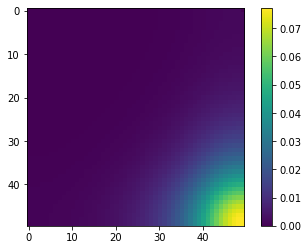

In [56]:
plt.imshow(I2[:,:,5000])
plt.colorbar()
plt.savefig("wave1.eps")




In [44]:
!pip install ffmpeg



In [ ]:
 ani.save('/Users/asaaf/Desktop/Stage/animation.gif', writer='ffmpeg', fps=60)



In [39]:
delta_z =10**(-8)
l = 1/R_0
c = 2*(1-l)**(1/2)
z1 = 0
z2 = 10**(3)
zstep = int((z2-z1)/delta_z)
S_s = []
I_s = []
P_s = []
Q_s = []

#t = tqdm(total=zstep)
for n in range(10**(2)):
    I_0 = 10**(-np.random.uniform(6,10))
    A = 1-10**(-np.random.uniform(6,20))
    Q_0 = -10**(-np.random.uniform(6,20))
    P_0 = 10**(-np.random.uniform(6,20))
    S_cur = A
    I_cur = I_0
    Q_cur = Q_0
    P_cur = P_0
    print(f"i = {i}; S_0 = {A:.15g};I_0 = {I_0:.2g}; Q_0={Q_0:.2g}; P_0={P_0:.2g}, didn't work")

    for i in range(1,zstep):
        P_pre = (1+c*delta_z)*P_cur + delta_z*(1/c)*I_cur*(S_cur-l)
        I_pre= -c*P_cur*delta_z + I_cur
        Q_pre = (1+delta_z*c)*Q_cur - delta_z*(1/c)* I_cur* S_cur
        S_pre =  -c*Q_cur*delta_z + S_cur
        if (abs(S_pre) > 1) or I_pre < 0:
            #print(f"not working, {i}")
            break
        if i%1000==0:
            S_s.append(S_pre)
            I_s.append(I_pre)
        S_cur = S_pre 
        I_cur = I_pre 
        Q_cur = Q_pre 
        P_cur = P_pre
        #t.set_postfix(S_pre=S_pre) #f"{S_pre:.2f}")
        #t.update()
    if i == zstep-1:
        print("it worked")
        print()
        break
    #else:
    #   print(f"i = {i}; S_0 = {A:.2g};I_0 = {I_0:.2g}; Q_0={Q_0:.2g}; P_0={P_0:.2g}, didn't work")
            

i = 128; S_0 = 1;I_0 = 1.1e-09; Q_0=-2.2e-11; P_0=9.5e-16, didn't work
i = 134720931; S_0 = 0.99999999938153;I_0 = 9.4e-07; Q_0=-1.7e-15; P_0=4.4e-08, didn't work
i = 3594716; S_0 = 0.999999999825536;I_0 = 7.4e-10; Q_0=-1.5e-11; P_0=1.4e-10, didn't work
i = 97376351; S_0 = 0.999999999999957;I_0 = 7.6e-08; Q_0=-8.1e-18; P_0=8.1e-09, didn't work
i = 13383354; S_0 = 0.99999999880958;I_0 = 6.9e-08; Q_0=-1.3e-19; P_0=3.3e-16, didn't work
i = 18302088; S_0 = 0.999999999999987;I_0 = 5.4e-10; Q_0=-5.4e-16; P_0=4.6e-18, didn't work
i = 134721160; S_0 = 0.999999999999996;I_0 = 3.5e-07; Q_0=-6.3e-14; P_0=6.5e-17, didn't work
i = 3059930; S_0 = 0.999999644427597;I_0 = 9.4e-09; Q_0=-6.9e-15; P_0=1e-15, didn't work
i = 134721162; S_0 = 0.999999999999999;I_0 = 3.1e-07; Q_0=-9.1e-08; P_0=6.6e-11, didn't work
i = 1; S_0 = 1;I_0 = 1e-07; Q_0=-6e-10; P_0=8.7e-17, didn't work
i = 9110946; S_0 = 0.99999999968;I_0 = 1.1e-10; Q_0=-3.9e-09; P_0=3.1e-12, didn't work


KeyboardInterrupt: 